# Fourier features to capture seasonality

In this notebook we will show how to create fourier features and how we can add them to our forecasting pipeline.

In [1]:
import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Data set synopsis

We will use the Victoria electricity demand dataset found here: 
https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf). It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). 

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] [K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
    MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
    Seasonal Patterns. arXiv preprint arXiv:2107.13462.](https://arxiv.org/pdf/2107.13462.pdf)

In [2]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

In [3]:
data.shape

(115368, 1)

The data is relatively large compared to the other datasets we have been working with. If the rest of this notebook runs too slowly on your laptop try filtering to a recent segment of the data. For example by running:

```Python
# Filter to the previous 3 years of the dataset
data = data.loc["2012":]
```

## Plot the data

There time series is high frequency and over a long period. Let's plot the previous three years.

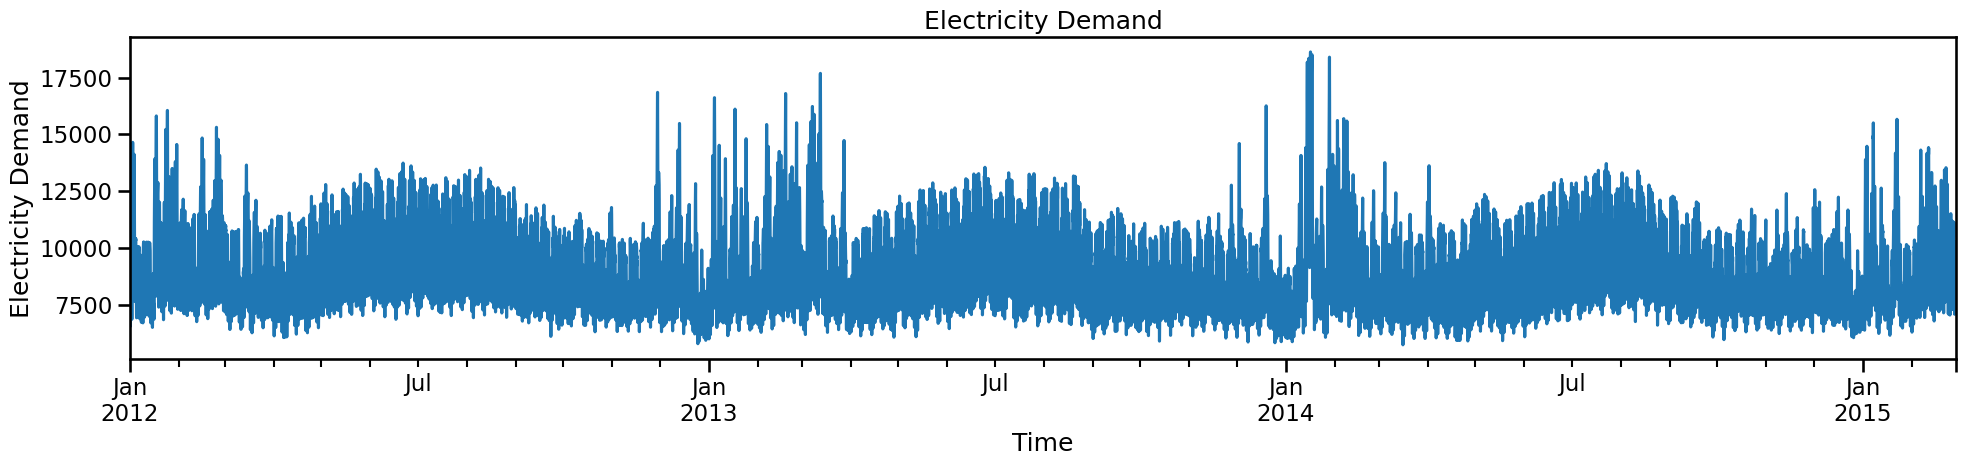

In [4]:
fig, ax = plt.subplots(figsize=[20, 5])
data.loc["2012":].plot(y="demand", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Demand")
ax.set_title("Electricity Demand")
plt.tight_layout()

# Creating Fourier features with sktime

In [5]:
from sktime.transformations.series.fourier import FourierFeatures

In [6]:
transformer = FourierFeatures(
    sp_list=[24, 24 * 7],  # list of seasonal periods (daily, weekly)
    fourier_terms_list=[3, 3],  # list of fourier terms (1pi, 2pi, 3pi)
    freq="H",  # Frequency of the time series (our data frequency)
    keep_original_columns=False,
)

transformer.fit(data)
result = transformer.transform(data)
result.head()

,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3
date_time,,,,,,,,,,,,
2002-01-01 00:00:00,0.000000,1.000000,0.000000,1.000000e+00,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2002-01-01 01:00:00,0.258819,0.965926,0.500000,8.660254e-01,7.071068e-01,7.071068e-01,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712
2002-01-01 02:00:00,0.500000,0.866025,0.866025,5.000000e-01,1.000000e+00,6.123234e-17,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928
2002-01-01 03:00:00,0.707107,0.707107,1.000000,6.123234e-17,7.071068e-01,-7.071068e-01,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883
2002-01-01 04:00:00,0.866025,0.500000,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969


Let's visualise the features that we're using to capture seasonality.

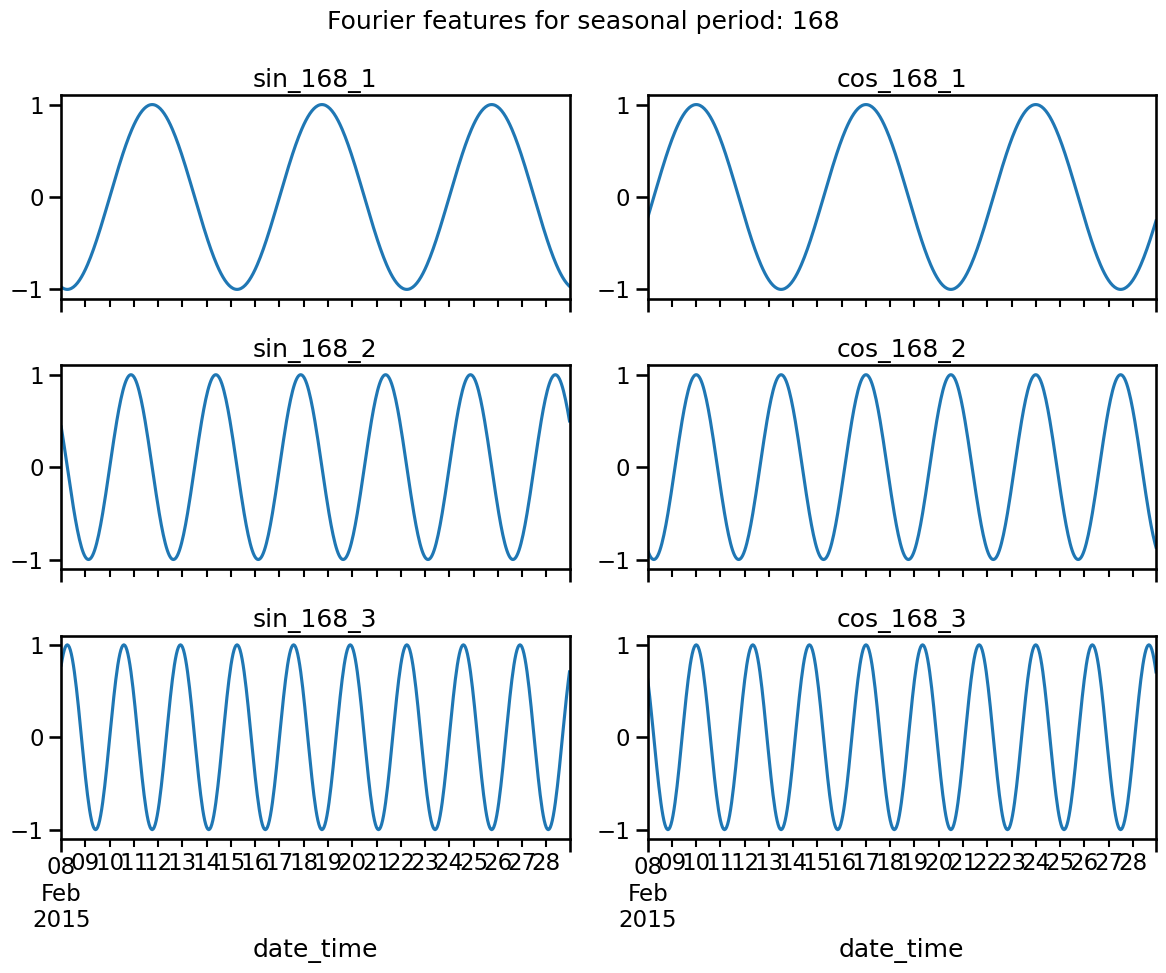

In [7]:
# Let's filter to the weekly seasonality Fourier features only
seasonal_period = 24 * 7
result_ = result.filter(like=f"_{seasonal_period}_").iloc[-seasonal_period * 3 :]

# Plot each Fourier feature associated to the specified seasonality
num_features = result_.shape[1]
fig, ax = plt.subplots(nrows=num_features // 2, ncols=2, figsize=(12, 10), sharex=True)
for feature, ax in zip(result_.columns, ax.flatten()):
    result_.loc[:, feature].plot(ax=ax)
    ax.set_title(feature)

fig.suptitle(f"Fourier features for seasonal period: {seasonal_period}", fontsize=18)
plt.tight_layout()

# here you can see the sin/cos weekly seasionaloty, in freq of 1,2,3. 

We have sine and cosine waves with frequencies which are integer multiples of `seasonal_period`. The number of features is equivalent to the number of `fourier_terms * 2`, the factor of 2 comes from the fact the we have both a sine and cosine wave associated with each frequency.

# Let's see how fourier features help capture seasonality.

Let's build a linear model using only fourier features to understand how they help capture seasonality.

In a linear model we have: $$y_t = \beta_0 + \beta_1x_1 + ... + \beta_Nx_N$$

where $N$ is the number of features.

For this dataset we want to model daily and weekly seasonality alongside other features, $x_i$. Effectively we want to fit a model that looks like the following:

$$y_t = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + S^{daily}_t + S^{weekly}_t$$

where $S^{daily}_t$ and $S^{weekly}_t$ represent the daily and weekly seasonal component. As discussed in lectures, when using fourier features we are modelling each of these seasonal components using a sum of sine and cosine functions which have frequencies that are integer multiples of the seasonal period:

$$
S^{daily}_t = \sum_{n=1}^{n_{daily}} A_{n}^{daily}sin(\frac{2\pi nt}{24}) + B_{n}^{daily}cos(\frac{2\pi nt }{24})
$$
$$
S^{weekly}_t = \sum_{n=1}^{n_{weekly}} A_{n}^{weekly}sin(\frac{2\pi nt}{24*7}) + B_{n}^{weekly}cos(\frac{2\pi nt }{24*7})
$$

where $A_{n}$ and $B_{n}$ are the coefficients (i.e., they're just additional $\beta$ coefficients corresponding to the sine and cosine features in the linear model) learned when we train the linear model, $n_{daily}$ & $n_{weekly}$ are hyperparameters which represents the number of sine and cosine features we want to use to model the respective seasonal component.

If we are only using fourier features, the linear model that we're effectively fitting is: 
$$
\begin{aligned}
y_t &= \sum_{p}\sum_{n=1}^{n_p} A_{n,p}sin(\frac{2\pi nt}{T_p}) + B_{n,p}cos(\frac{2\pi nt }{T_p}) \\
&= \sum_{n=1}^{n_{daily}} A_{n}^{daily}sin(\frac{2\pi nt}{24}) + B_{n}^{daily}cos(\frac{2\pi nt }{24}) +  \sum_{n=1}^{n_{weekly}} A_{n}^{weekly}sin(\frac{2\pi nt}{24*7}) + B_{n}^{weekly}cos(\frac{2\pi nt }{24*7})
\end{aligned}
$$

where $p$ represents the seasonality we are modelling.

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


In [10]:
fourier_feats = FourierFeatures(
    # List of seasonal periods
    sp_list=[
        24,       # daily seasonality
        24 * 7,   # weekly seasonality
        24 * 365, # yearly seasonality
    ],
    # The number of fourier components for each seasonality.
    fourier_terms_list=[
        3,  # daily seasonality
        3,  # weekly seasonality
        3,  # yearly seasonality
    ],
    freq="H",  # Frequency of time series
    keep_original_columns=False,
)

Split data into train and test.

In [11]:
# Hold out the last 2 weeks of obeservations
holdout_size = 24 * 7 * 2 # 24h * 7 days * 2 = two weeks
df_train = data.iloc[:-holdout_size] # train data frame
df_test = data.iloc[-holdout_size:]  # test data frame

Creat fourier features.

In [12]:
target = ["demand"]

X_train = fourier_feats.fit_transform(df_train)
y_train = df_train.loc[:, target]

X_test = fourier_feats.transform(df_test)
y_test = df_test.loc[:, target]

We have the fourier features for both the training and testing period. So we can use these to directly predict the entire test period without having to use direct or recursive forecasting. We show later in this notebook how to use fourier features alongside other features which requires us to use a direct or recursive forecasting workflow to do multistep forecasting.

In [13]:
# Create the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

y_forecast_test = model.predict(X_test)
y_forecast_test = pd.DataFrame(y_forecast_test, index=X_test.index, columns=target)

Text(0.5, 1.0, 'Forecast with LinearRegression()')

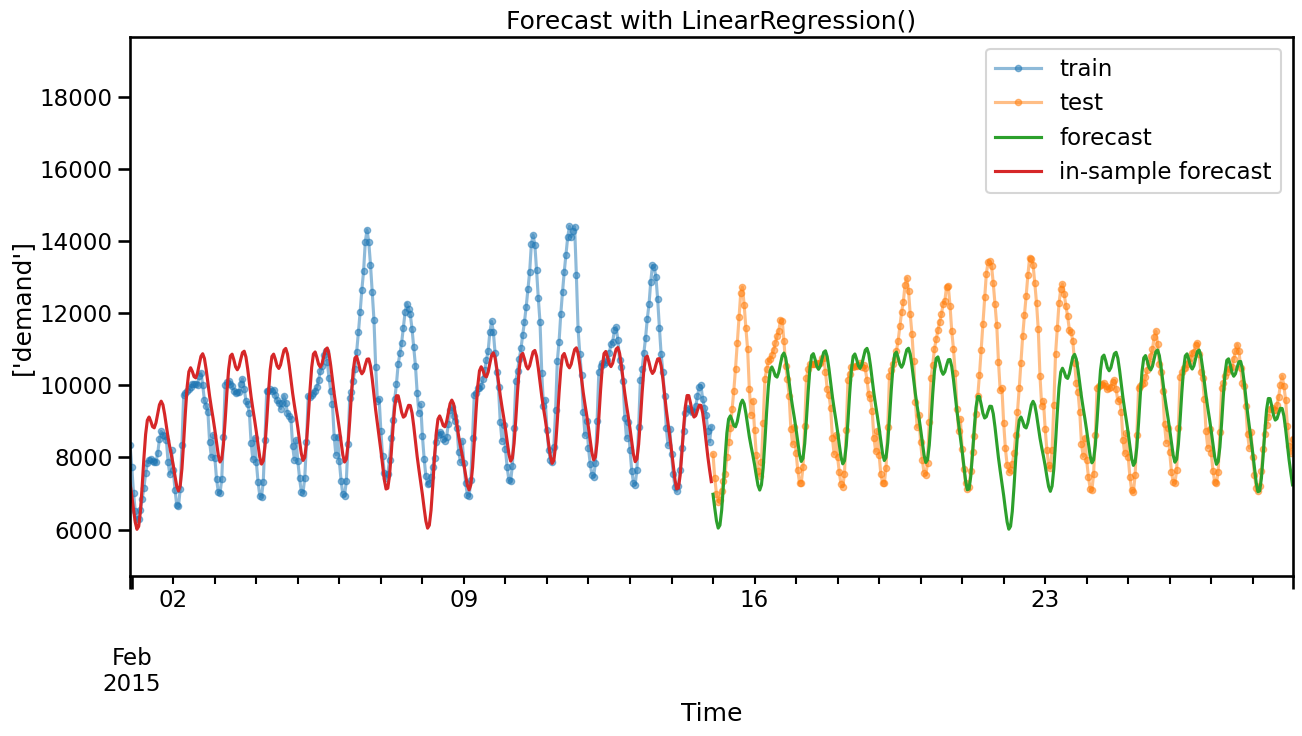

In [14]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[15, 7])

# Plot training set.
y_train.plot(ax=ax, marker=".", alpha=0.5)
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker=".", alpha=0.5)
# Plot forecast in testing data.
y_forecast_test.plot(ax=ax)
# Plot forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=2))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

We can see that just using Fourier features we are able to capture daily and weekly seasonality. In the absence of other features the forecast is completely periodic; this is expected because the model is just a sum of sine and cosine functions.

Try adjusting the number of Fourier terms in the `fourier_terms_list` argument and see how it changes the predictions.

Let's add more features alongside Fourier features and build a forecast!

# Let's build some forecasts!

Let's build a recursive forecast and see how we can include Fourier features in our feature engineering pipeline.

In [15]:
# Fourier features
from sktime.transformations.series.fourier import FourierFeatures

# --- The transformers from earlier in the course. --- #
# Date time features to capture seasonality
from sktime.transformations.series.date import DateTimeFeatures
# Require OneHotEncoder to create seasonal dummy variables
from sklearn.preprocessing import OneHotEncoder
# Lag and window features
from sktime.transformations.series.summarize import WindowSummarizer
# Time features for trend 
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
# Rescaling transformer for linear models with regularisation
from sklearn.preprocessing import MinMaxScaler
# Pipelines to create feature engineering pipeline
from sklearn.pipeline import make_pipeline, make_union
# Used to reset sklearn estimators
from sklearn.base import clone

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn 0.12
                                       # for this feature

In [16]:
df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


Specify target name.

In [17]:
target = ["demand"]  # Note: it's in a list.
                    # This ensures we'll get
                    # a dataframe when using df.loc[:, target]
                    # rather than a pandas Series.
                    # This can also be useful if we have
                    # multiple targets.

Prepare our transformers.

In [18]:
## Polynomial time features for trend ##
time_feats = make_pipeline(
    TimeSince(), PolynomialFeatures(degree=1, include_bias=False)
)

## Datetime features ##
# Specify which datetime features to create
datetime_features = [
    "is_weekend", # for capture weekly (weekend) seasionalioty
]

datetime_feats = DateTimeFeatures(
    manual_selection=datetime_features,
    keep_original_columns=False,
)

## fourier features ##
fourier_feats = FourierFeatures(
    sp_list=[24, 24 * 7],      # seasionalities to capture (day, week)
    fourier_terms_list=[3, 3], # fourier freq to each seasionality
    freq="H", # the freq of our time series data                  
    keep_original_columns=False, 
)


# Features computed from the target.
# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": [1,2,3,4] # np.arange(1, 25),  # Lag features.
    #    "mean": [[1, 24], [1, 24 * 7]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

Create a pipeline to create all our features.

In [19]:
# combine all the transformans into pipe line
pipeline = make_union(
    datetime_feats,
    fourier_feats,
    time_feats,
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [20]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('datetimefeatures',
                                                 DateTimeFeatures(manual_selection=['is_weekend'])),
                                                ('fourierfeatures',
                                                 FourierFeatures(fourier_terms_list=[3, 3], freq='H', sp_list=[24, 168])),
                                                ('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 3, 4]}, target_cols=['demand'],
                 truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [21]:
pipeline.fit_transform(df.head())

,is_weekend,sin_24_1,cos_24_1,sin_24_2,cos_24_2,sin_24_3,cos_24_3,sin_168_1,cos_168_1,sin_168_2,cos_168_2,sin_168_3,cos_168_3,time_since_2002-01-01 00:00:00,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4
date_time,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00,0.817386,0.675273,0.0,0.0
2002-01-01 01:00:00,0.0,0.298858,0.931852,0.500000,0.910684,7.071068e-01,0.853553,0.250876,0.937391,0.253533,0.937061,0.258052,0.936507,0.25,0.817386,0.675273,0.0,0.0
2002-01-01 02:00:00,0.0,0.577350,0.732051,0.866025,0.666667,1.000000e+00,0.500000,0.501402,0.749650,0.505648,0.748596,0.512858,0.746826,0.50,1.000000,0.675273,0.0,0.0
2002-01-01 03:00:00,0.0,0.816497,0.414214,1.000000,0.333333,7.071068e-01,0.146447,0.751226,0.437041,0.754935,0.435659,0.761216,0.433343,0.75,0.437640,1.000000,0.0,0.0
2002-01-01 04:00:00,0.0,1.000000,0.000000,0.866025,0.000000,1.224647e-16,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.00,0.000000,0.000000,1.0,0.0


Let's reset our feature engineering pipeline.

In [22]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [23]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [24]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.
forecast_start_time = df.index.max() - pd.DateOffset(
    weeks=2
)  # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24 * 7 * 2

# Define the model.
model = LinearRegression()

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(
    forecast_start_time, periods=num_of_forecast_steps, freq="H"
)

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1)  # We need the latest 24*7 time periods
# in our predict dataframe to build our
# window features.

Let's create our training dataframe.

In [25]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's compute our `X_train` and `y_train` and fit our model!

In [26]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which have
# certain characters (e.g., ":"). We replace these
# with `_`.
if "lightgbm" in model.__module__:  # checks if model is from lightgbm
    X_train = X_train.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "_", x))


# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

LinearRegression()

Let's prepare the dataframe that we will pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data.

In [27]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([df_predict, pd.DataFrame(index=forecast_horizon)])

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [28]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]]

    # Predict one step ahead.
    y_pred = model.predict(X_test)

    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forest horizon.

In [29]:
# --- GET FORECAST AND TEST VALUES --- #
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [30]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

Text(0.5, 1.0, 'Recursive forecast with LinearRegression()')

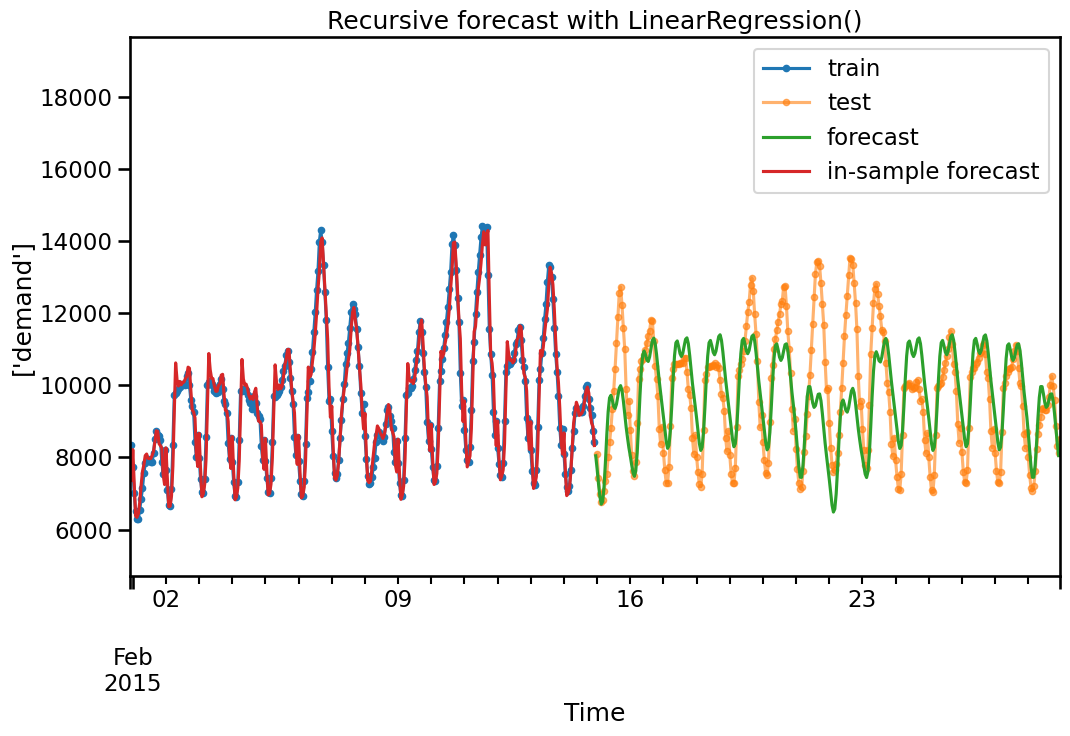

In [31]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker=".")
# Plot actuals in forecasting horizon.
y_test.iloc[-24 * 7 * 2 :].plot(ax=ax, marker=".", alpha=0.6)
# Plot forecast.
y_forecast.iloc[-24 * 7 * 2 :].plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=2))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Recursive forecast with {model}")

Let's compute the RMSE of this forecast.

In [32]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error

mean_squared_error(
    y_true=y_test.loc[y_forecast.index], y_pred=y_forecast, squared=False
)

1189.4848395594738

Feel free to change the dates, try different models, and different features!